In [1]:
%matplotlib inline
import numpy as np
from scipy import stats
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt

class Object(object): pass

# 3.1 Sampling from a grid-approximate posterior

## Code 3.2

Text(0.5, 1.0, 'Posterior')

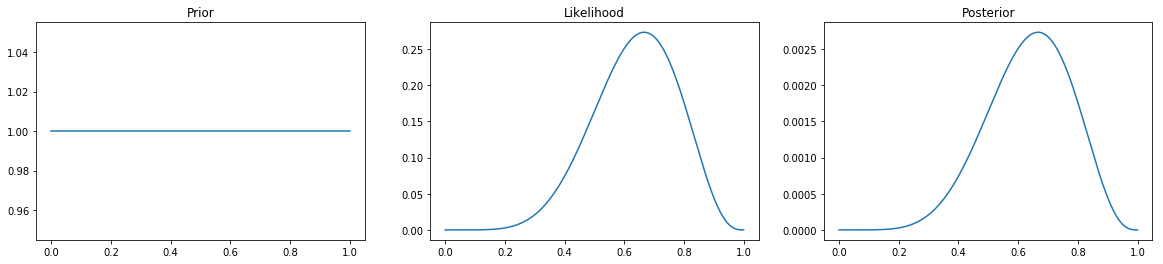

In [2]:
p_grid = np.linspace(0, 1, 1000)
prior = np.repeat(1, p_grid.shape[0])
likelihood = stats.binom.pmf(n=9, k=6, p=p_grid)

posterior = prior * likelihood
posterior /= posterior.sum()

_32 = Object()
_32.fig = plt.figure(figsize=(20, 4))
_32.axes = _32.fig.add_subplot(131)
_32.axes.plot(p_grid, prior)
_32.axes.set_title("Prior")

_32.axes = _32.fig.add_subplot(132)
_32.axes.plot(p_grid, likelihood)
_32.axes.set_title("Likelihood")

_32.axes = _32.fig.add_subplot(133)
_32.axes.plot(p_grid, posterior)
_32.axes.set_title("Posterior")

## Code 3.3

In [3]:
samples = np.random.choice(p_grid, size=1000, p=posterior, replace=True)

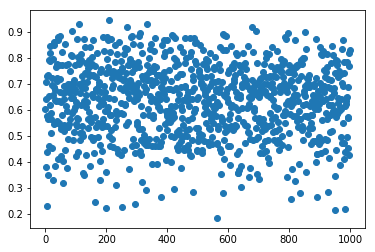

In [4]:
plt.plot(samples, marker='o', linestyle='None')

## Kernel Density Estimation

https://en.wikipedia.org/wiki/Kernel_density_estimation

In [5]:
def dens(x, samples, smoothing_h=None):
    phi = lambda x: np.exp(-0.5 * x**2) / np.sqrt(2 * np.pi)
    # Rule of thumb smoothing, see https://en.wikipedia.org/wiki/Kernel_density_estimation
    h = smoothing_h if smoothing_h is not None \
        else np.std(samples) * (4 / 3 / samples.shape[0])**(1/5)
    result = []
    for x_i in x:
        result.append(np.mean(phi((x_i - samples) / h)) / h)
    return np.array(result)

Smoothing too low--$0.01$:

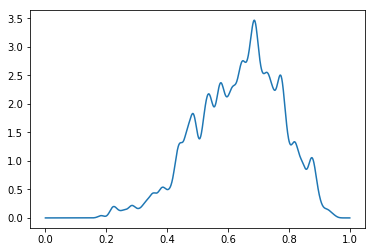

In [6]:
plt.plot(p_grid, dens(p_grid, samples, 0.01))

Smoothing too high--$1.0$:

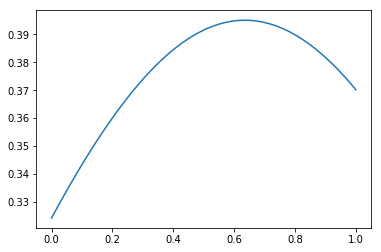

In [7]:
plt.plot(p_grid, dens(p_grid, samples, 1))

Rule of thumb: $(\frac{4}{3n})^\frac{1}{5}\hat\sigma \approx 1.06\hat\sigma n^{-1/5}$, where $\hat\sigma$ is the sample standard error.

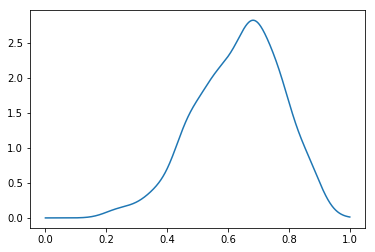

In [8]:
plt.plot(p_grid, dens(p_grid, samples))

Increase number of samples:

CPU times: user 3.68 s, sys: 40 ms, total: 3.72 s
Wall time: 1.9 s


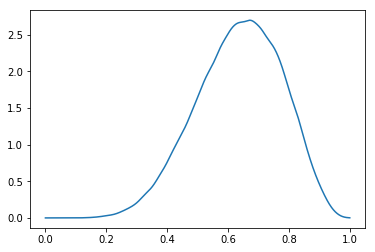

In [9]:
%%time
plt.plot(p_grid, dens(p_grid, np.random.choice(p_grid, size=int(1e5), p=posterior, replace=True)))

# 3.2. Sampling to Summarize

### Code 3.6

In [10]:
# Add up posterior probability where  p < 0.5
np.sum(posterior[p_grid < 0.5])

0.17187458902022873

Same result, but use sample:

### Code 3.7

In [11]:
np.sum(samples < 0.5), np.sum(samples < 0.5) / samples.shape[0]

(184, 0.184)

### Code 3.8

In [12]:
np.sum((samples > 0.5) & (samples < 0.75)) / samples.shape[0]

0.6

### Code 3.9 - Percentile

In [31]:
def quantile(arr, perc_list):
    def single_quantile(arr, perc):
        k = (arr.shape[0] - 1) * perc
        f = np.floor(k)
        c = np.ceil(k)
        result = None
        if f == c:
            result = arr[int(k)]
        else:
            d0 = arr[int(f)] * (c - k)
            d1 = arr[int(c)] * (k - f)
            result = d0 + d1
        return result
    
    arr = np.sort(arr)
    
    if isinstance(perc_list, list):
        perc_list = np.array(perc_list)
        
    if isinstance(perc_list, np.ndarray):
        result = np.zeros_like(perc_list)
        for i, p in enumerate(perc_list):
            result[i] = single_quantile(arr, p)
    else:
        result = single_quantile(arr, perc_list)
    return result

In [14]:
quantile(samples, 0.8)

0.7577577577577577

### Code 3.10

In [15]:
quantile(samples, np.array([0.1, 0.9]))

array([0.44914915, 0.80900901])

### Code 3.11

In [16]:
p_grid = np.linspace(0, 1, 1000)
prior = np.repeat(1, 1000)
likelihood = stats.binom.pmf(k=3, n=3, p=p_grid)
posterior = prior * likelihood
posterior /= np.sum(posterior)
samples = np.random.choice(p_grid, size=1000, replace=True, p=posterior)

In [17]:
ret = quantile(samples, np.array([0.25, 0.75]))
print(ret)

[0.70970971 0.93693694]


Text(0.5, 1.0, '50% HPDI')

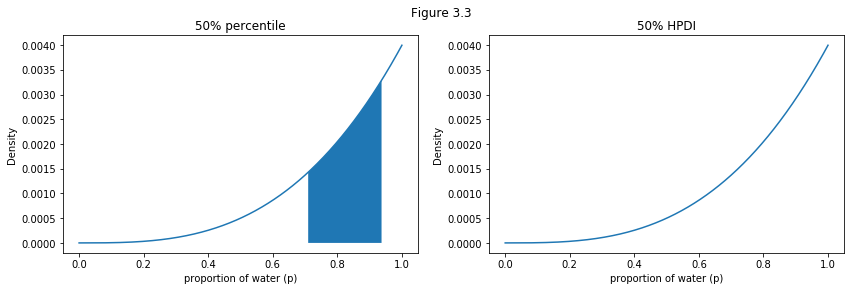

In [30]:
indices = np.where((p_grid >= ret[0]) & (p_grid <= ret[1]))
x = p_grid[indices]
f = posterior[indices]

fig = plt.figure(figsize=(14, 4))
axes = fig.add_subplot(121)
axes.plot(p_grid, posterior)
axes.fill_between(x, f)
axes.set_title("50% percentile")
axes.set_xlabel("proportion of water (p)")
axes.set_ylabel("Density")
fig.suptitle("Figure 3.3")

axes = fig.add_subplot(122)
axes.plot(p_grid, posterior)
axes.set_xlabel("proportion of water (p)")
axes.set_ylabel("Density")
axes.set_title("50% HPDI")